In [2]:
from torchaudio.transforms import MFCC

# Parameters for MFCC extraction and frame standardization
sample_rate = 16000
n_mfcc = 20
melkwargs = {
    "n_fft": 400,       # frame size of 25ms
    "hop_length": 160,  # hop size of 10ms
    "n_mels": 40        # number of Mel filterbanks
}
max_frames = 250  # Number of time frames to pad/trim to (e.g., ~2s of audio)

# Initialize the MFCC transform
mfcc_transform = MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs=melkwargs
)

In [3]:
import torch
import torchaudio

class LibriSpeechMFCC(torch.utils.data.Dataset):
    """
    PyTorch Dataset that wraps LibriSpeech and applies MFCC transform,
    with optional padding/truncation and normalization.
    Returns:
        mfcc: Tensor of shape (n_mfcc, max_frames)
        speaker_id: int
    """
    def __init__(self, root="./data", url="train-clean-100", download=False,
                 transform=None, max_frames=250):
        self.dataset = torchaudio.datasets.LIBRISPEECH(root, url=url, download=download)
        self.transform = transform
        self.max_frames = max_frames

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        waveform, sr, _, speaker_id, _, _ = self.dataset[idx]
        # Resample if needed
        if sr != sample_rate:
            waveform = torchaudio.functional.resample(waveform, sr, sample_rate)
        # Convert to mono if needed
        if waveform.size(0) > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        # Apply MFCC transform: output shape (1, n_mfcc, time_frames)
        mfcc = self.transform(waveform).squeeze(0)  # now (n_mfcc, time_frames)

        # 1) Pad or truncate to fixed number of frames
        t = mfcc.shape[1]
        if t < self.max_frames:
            pad = torch.zeros((n_mfcc, self.max_frames - t))
            mfcc = torch.cat((mfcc, pad), dim=1)
        else:
            mfcc = mfcc[:, :self.max_frames]

        # 2) Normalize per coefficient (mean=0, std=1)
        mean = mfcc.mean(dim=1, keepdim=True)
        std = mfcc.std(dim=1, keepdim=True) + 1e-6
        mfcc = (mfcc - mean) / std

        return mfcc, speaker_id


In [5]:
import os

# Ensure data directory exists and dataset is downloaded
os.makedirs("./data", exist_ok=True)
dataset = LibriSpeechMFCC(
    root="./data",
    url="train-clean-100",
    download=not os.path.isdir("./data/LibriSpeech"),
    transform=mfcc_transform,
    max_frames=max_frames
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=2
)

print(dataloader)

In [ ]:

# Iterate one batch to check shapes
for batch_mfcc, batch_speaker in dataloader:
    print("MFCC batch shape:", batch_mfcc.shape)  # (batch, n_mfcc, max_frames)
    print("Speaker IDs:", batch_speaker)
    break


# 2nd method

In [8]:
import torchaudio

# Charger un exemple audio de LibriSpeech (par exemple train-clean-100)
waveform, sample_rate = torchaudio.load("data/LibriSpeech/train-clean-100/200/124139/200-124139-0000.flac")

if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)

In [9]:
import torchaudio.transforms as T

# Créer une transformation MFCC
mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=40,                 # Nombre de coefficients MFCC
    melkwargs={
        'n_fft': 400,
        'hop_length': 160,
        'n_mels': 64
    }
)

mfcc = mfcc_transform(waveform)  # forme: [1, n_mfcc, time_frames]

In [10]:
# Ajouter la dimension batch
mfcc = mfcc.unsqueeze(0)  # shape: [1, 1, n_mfcc, time_frames]


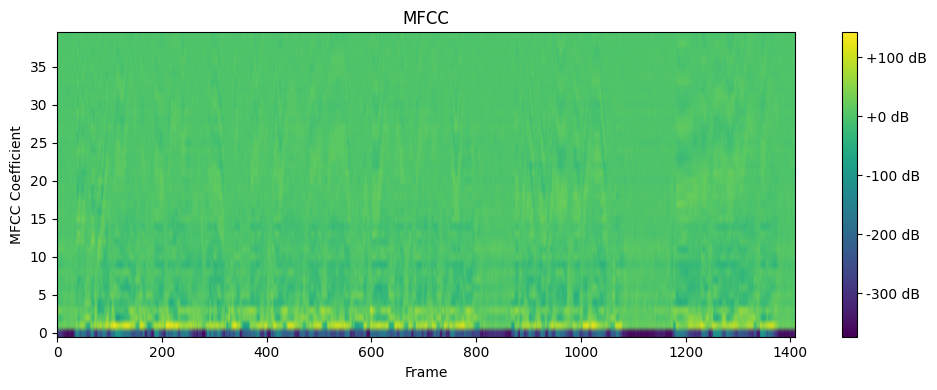

In [11]:
import matplotlib.pyplot as plt
import torchaudio.functional as F

# mfcc a la forme [1, 1, n_mfcc, time_frames], on enlève les dimensions inutiles
mfcc_to_plot = mfcc.squeeze().numpy()  # forme: [n_mfcc, time_frames]

plt.figure(figsize=(10, 4))
plt.imshow(mfcc_to_plot, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.xlabel('Frame')
plt.ylabel('MFCC Coefficient')
plt.tight_layout()
plt.show()

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class SpeakerCNN(nn.Module):
    def __init__(self, num_classes):
        super(SpeakerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 10 * 12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 16, ..., ...]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 32, ..., ...]
        x = x.view(x.size(0), -1)             # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
